# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.formula.api as smf

In [29]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


In [31]:
df.isnull().sum()

age            0
sex            0
cp             0
trestbps       0
chol           0
fbs            0
restecg        0
thalach        0
exang          0
oldpeak        0
slope          0
ca             0
thal           0
num            0
flag_doente    0
dtype: int64

In [32]:
df.duplicated().sum()

0

1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

#### Criar a Função para Análise Bivariada

In [33]:
def bivariada_analysis(df, response_var, explanatory_var):
    """
    Função para montar a análise bivariada.
    
    Parâmetros:
    df: DataFrame contendo os dados a serem avaliados
    response_var: String contendo o nome da variável resposta
    explanatory_var: String contendo o nome da variável explicativa
    
    Retorna:
    DataFrame com os dados da bivariada
    """
    # Criar a tabela de contingência
    crosstab = pd.crosstab(df[explanatory_var], df[response_var] > 0, margins=True)
    crosstab.columns = ['Saudaveis', 'Doentes', 'Total']
    
    # Calcular as métricas
    crosstab['Media Doentes'] = crosstab['Doentes'] / crosstab['Total']
    crosstab['Odds'] = crosstab['Doentes'] / crosstab['Saudaveis']
    total_odds = crosstab.loc['All', 'Doentes'] / crosstab.loc['All', 'Saudaveis']
    crosstab['Odds Ratio'] = crosstab['Odds'] / total_odds
    crosstab['Logito'] = np.log(crosstab['Odds'])
    crosstab['WOE'] = np.log(crosstab['Odds Ratio'])
    
    return crosstab

#### Aplicar a Função a Três Variáveis Qualitativas

In [34]:
# Variáveis qualitativas escolhidas: 'sex', 'cp', 'fbs'
response_var = 'num'

bivariada_sex = bivariada_analysis(df, response_var, 'sex')
bivariada_cp = bivariada_analysis(df, response_var, 'cp')
bivariada_fbs = bivariada_analysis(df, response_var, 'fbs')

print("Bivariada para 'sex':")
print(bivariada_sex)

print("\nBivariada para 'cp':")
print(bivariada_cp)

print("\nBivariada para 'fbs':")
print(bivariada_fbs)

Bivariada para 'sex':
     Saudaveis  Doentes  Total  Media Doentes      Odds  Odds Ratio    Logito   
sex                                                                             
0.0         72       25     97       0.257732  0.347222    0.409672 -1.057790  \
1.0         92      114    206       0.553398  1.239130    1.461996  0.214410   
All        164      139    303       0.458746  0.847561    1.000000 -0.165392   

          WOE  
sex            
0.0 -0.892398  
1.0  0.379802  
All  0.000000  

Bivariada para 'cp':
     Saudaveis  Doentes  Total  Media Doentes      Odds  Odds Ratio    Logito   
cp                                                                              
1.0         16        7     23       0.304348  0.437500    0.516187 -0.826679  \
2.0         41        9     50       0.180000  0.219512    0.258993 -1.516347   
3.0         68       18     86       0.209302  0.264706    0.312315 -1.329136   
4.0         39      105    144       0.729167  2.692308    3.1765

#### Analisar Qual Variável Discrimina Mais o Risco

In [35]:
def analyze_risk_discrimination(bivariadas):
    """
    Função para analisar qual bivariada discrimina mais o risco.
    
    Parâmetros:
    bivariadas: Lista de DataFrames com as bivariadas
    
    Retorna:
    String com o nome da variável que discrimina mais o risco
    """
    max_woe = float('-inf')
    best_var = ""
    
    for var_name, bivariada in bivariadas.items():
        # Considerar o valor absoluto do WOE para determinar a discriminação
        max_abs_woe = bivariada['WOE'].abs().max()
        
        if max_abs_woe > max_woe:
            max_woe = max_abs_woe
            best_var = var_name
            
    return best_var

# Analisar qual variável discrimina mais o risco
bivariadas = {
    'sex': bivariada_sex,
    'cp': bivariada_cp,
    'fbs': bivariada_fbs
}

best_variable = analyze_risk_discrimination(bivariadas)
print(f"A variável que discrimina mais o risco é: {best_variable}")


A variável que discrimina mais o risco é: cp


2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [36]:
def bivariada_quantitative(df, response_var, explanatory_var, num_categories=5):
    """
    Função para categorizar variáveis quantitativas contínuas e montar a análise bivariada.
    
    Parâmetros:
    df: DataFrame contendo os dados a serem avaliados
    response_var: String contendo o nome da variável resposta
    explanatory_var: String contendo o nome da variável explicativa
    num_categories: Número de categorias para quebrar a variável quantitativa (default=5)
    
    Retorna:
    DataFrame com os dados da bivariada
    """
    # Categorizar a variável quantitativa contínua
    df['category'] = pd.cut(df[explanatory_var], bins=num_categories, labels=[f'Group {i}' for i in range(1, num_categories + 1)])
    
    # Criar a tabela de contingência
    crosstab = pd.crosstab(df['category'], df[response_var] > 0, margins=True)
    crosstab.columns = ['Saudaveis', 'Doentes', 'Total']
    
    # Calcular as métricas
    crosstab['Media Doentes'] = crosstab['Doentes'] / crosstab['Total']
    crosstab['Odds'] = crosstab['Doentes'] / crosstab['Saudaveis']
    total_odds = crosstab.loc['All', 'Doentes'] / crosstab.loc['All', 'Saudaveis']
    crosstab['Odds Ratio'] = crosstab['Odds'] / total_odds
    crosstab['Logito'] = np.log(crosstab['Odds'])
    crosstab['WOE'] = np.log(crosstab['Odds Ratio'])
    
    return crosstab

# Exemplo de uso da função para a variável 'age'
response_var = 'num'
explanatory_var = 'age'
num_categories = 5

bivariada_age = bivariada_quantitative(df, response_var, explanatory_var, num_categories)

print("Bivariada para 'age':")
print(bivariada_age)

Bivariada para 'age':
          Saudaveis  Doentes  Total  Media Doentes      Odds  Odds Ratio   
category                                                                   
Group 1           8        3     11       0.272727  0.375000    0.442446  \
Group 2          50       21     71       0.295775  0.420000    0.495540   
Group 3          56       41     97       0.422680  0.732143    0.863823   
Group 4          40       67    107       0.626168  1.675000    1.976259   
Group 5          10        7     17       0.411765  0.700000    0.825899   
All             164      139    303       0.458746  0.847561    1.000000   

            Logito       WOE  
category                      
Group 1  -0.980829 -0.815437  
Group 2  -0.867501 -0.702108  
Group 3  -0.311780 -0.146387  
Group 4   0.515813  0.681206  
Group 5  -0.356675 -0.191282  
All      -0.165392  0.000000  


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [37]:
# Criar a fórmula do modelo de regressão logística
formula = 'flag_doente ~ sex + cp + trestbps + age'

# Ajustar o modelo de regressão logística
logit_model = smf.logit(formula, data=df).fit()

# Exibir o resumo dos resultados do modelo
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.510076
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      298
Method:                           MLE   Df Model:                            4
Date:                Sat, 29 Jun 2024   Pseudo R-squ.:                  0.2605
Time:                        17:57:22   Log-Likelihood:                -154.55
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.264e-22
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.1167      1.608     -6.915      0.000     -14.267      -7.966
sex            1.8021      0.

### Interpretação dos Coeficientes

1. **Intercepto (-11.1167):**
   - Log-odds de ter a doença quando todas as variáveis são zero. Probabilidade de doença é muito baixa.

2. **sex (1.8021):**
   - Homens têm maior probabilidade de ter a doença do que mulheres.

3. **cp (1.1403):**
   - Tipos diferentes de dor no peito aumentam a probabilidade de ter a doença.

4. **trestbps (0.0214):**
   - Aumento na pressão arterial em repouso está associado a um aumento na probabilidade de ter a doença.

5. **age (0.0582):**
   - Idade mais avançada está associada a um aumento na probabilidade de ter a doença.


4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

In [38]:
# Calcular as probabilidades previstas pelo modelo
df['predicted_prob'] = logit_model.predict(X)
print(df[['predicted_prob']].head())


   predicted_prob
0        0.196041
1        0.928431
2        0.846558
3        0.276207
4        0.024768


In [39]:
# Categorizar a probabilidade prevista em 5 grupos
df['prob_group'] = pd.qcut(df['predicted_prob'], q=5, labels=False) + 1
print(df[['predicted_prob', 'prob_group']].head())


   predicted_prob  prob_group
0        0.196041           2
1        0.928431           5
2        0.846558           5
3        0.276207           2
4        0.024768           1


In [40]:
# Calcular a probabilidade prevista média por grupo
predicted_prob_mean = df.groupby('prob_group')['predicted_prob'].mean()
print(predicted_prob_mean)


prob_group
1    0.076255
2    0.249060
3    0.457982
4    0.673059
5    0.837449
Name: predicted_prob, dtype: float64


In [41]:
# Calcular a taxa de eventos por grupo
event_rate = df.groupby('prob_group')['flag_doente'].mean()
print(event_rate)


prob_group
1    0.098361
2    0.183333
3    0.491803
4    0.683333
5    0.836066
Name: flag_doente, dtype: float64


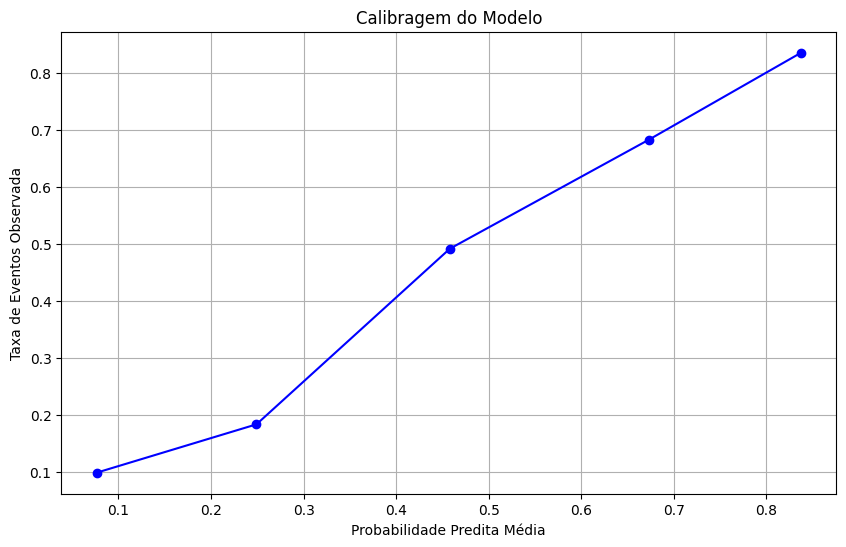

In [42]:
# Plotar o gráfico
plt.figure(figsize=(10, 6))
plt.plot(predicted_prob_mean, event_rate, marker='o', linestyle='-', color='b')
plt.xlabel('Probabilidade Predita Média')
plt.ylabel('Taxa de Eventos Observada')
plt.title('Calibragem do Modelo')
plt.grid(True)
plt.show()

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

* Acurácia

In [43]:
from sklearn.metrics import accuracy_score

# Prever as classes com base em um threshold de 0.5
df['predicted_class'] = (df['predicted_prob'] >= 0.5).astype(int)

# Calcular a acurácia
accuracy = accuracy_score(df['flag_doente'], df['predicted_class'])
print("Acurácia:", accuracy)


Acurácia: 0.7788778877887789


* Gini

In [44]:
from sklearn.metrics import roc_auc_score

# Calcular a AUC
auc = roc_auc_score(df['flag_doente'], df['predicted_prob'])

# Calcular o GINI
gini = 2 * auc - 1
print("GINI:", gini)


GINI: 0.6622214423583084


* KS

In [45]:
from scipy.stats import ks_2samp

# Separar as probabilidades previstas para as duas classes
prob_doentes = df[df['flag_doente'] == 1]['predicted_prob']
prob_nao_doentes = df[df['flag_doente'] == 0]['predicted_prob']

# Calcular o KS
ks_statistic, ks_p_value = ks_2samp(prob_doentes, prob_nao_doentes)
print("KS Statistic:", ks_statistic)


KS Statistic: 0.5840498333040884


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

* Adicionando variáveis

In [46]:
# Adicionar variáveis adicionais ao modelo
formula = 'flag_doente ~ sex + cp + trestbps + age + chol + thalach + exang'

# Ajustar o modelo de regressão logística
logit_model_add = smf.logit(formula, data=df).fit()

# Calcular as probabilidades previstas pelo modelo
df['predicted_prob_add'] = logit_model_add.predict(df)

# Prever as classes com base em um threshold de 0.5
df['predicted_class_add'] = (df['predicted_prob_add'] >= 0.5).astype(int)

# Calcular a acurácia
accuracy_add = accuracy_score(df['flag_doente'], df['predicted_class_add'])
print("Acurácia com variáveis adicionais:", accuracy_add)

# Calcular a AUC
auc_add = roc_auc_score(df['flag_doente'], df['predicted_prob_add'])

# Calcular o GINI
gini_add = 2 * auc_add - 1
print("GINI com variáveis adicionais:", gini_add)

# Separar as probabilidades previstas para as duas classes
prob_doentes_add = df[df['flag_doente'] == 1]['predicted_prob_add']
prob_nao_doentes_add = df[df['flag_doente'] == 0]['predicted_prob_add']

# Calcular o KS
ks_statistic_add, ks_p_value_add = ks_2samp(prob_doentes_add, prob_nao_doentes_add)
print("KS Statistic com variáveis adicionais:", ks_statistic_add)


Optimization terminated successfully.
         Current function value: 0.448501
         Iterations 7
Acurácia com variáveis adicionais: 0.7986798679867987
GINI com variáveis adicionais: 0.7404807861028251
KS Statistic com variáveis adicionais: 0.6179592911037024


* Remover Variáveis

In [47]:
# Remover variáveis do modelo
formula = 'flag_doente ~ sex + age + trestbps'

# Ajustar o modelo de regressão logística
logit_model_rem = smf.logit(formula, data=df).fit()

# Calcular as probabilidades previstas pelo modelo
df['predicted_prob_rem'] = logit_model_rem.predict(df)

# Prever as classes com base em um threshold de 0.5
df['predicted_class_rem'] = (df['predicted_prob_rem'] >= 0.5).astype(int)

# Calcular a acurácia
accuracy_rem = accuracy_score(df['flag_doente'], df['predicted_class_rem'])
print("Acurácia com variáveis removidas:", accuracy_rem)

# Calcular a AUC
auc_rem = roc_auc_score(df['flag_doente'], df['predicted_prob_rem'])

# Calcular o GINI
gini_rem = 2 * auc_rem - 1
print("GINI com variáveis removidas:", gini_rem)

# Separar as probabilidades previstas para as duas classes
prob_doentes_rem = df[df['flag_doente'] == 1]['predicted_prob_rem']
prob_nao_doentes_rem = df[df['flag_doente'] == 0]['predicted_prob_rem']

# Calcular o KS
ks_statistic_rem, ks_p_value_rem = ks_2samp(prob_doentes_rem, prob_nao_doentes_rem)
print("KS Statistic com variáveis removidas:", ks_statistic_rem)


Optimization terminated successfully.
         Current function value: 0.607880
         Iterations 5
Acurácia com variáveis removidas: 0.6765676567656765
GINI com variáveis removidas: 0.43841024741182677
KS Statistic com variáveis removidas: 0.3526057203018073


#### Conclusão: Comparando os resultados e escolhendo o melhor modelo:

### Resumo Comparativo dos Modelos

#### Modelo 1 (Original):
- **Acurácia:** 0.7789
- **GINI:** 0.6622
- **KS Statistic:** 0.5840

#### Modelo 2 (Adição de Variáveis):
- **Acurácia:** 0.7987
- **GINI:** 0.7405
- **KS Statistic:** 0.6180

#### Modelo 3 (Remoção de Variáveis):
- **Acurácia:** 0.6766
- **GINI:** 0.4384
- **KS Statistic:** 0.3526

### Conclusão
O **Modelo 2**, com adição de variáveis, apresentou a melhor performance com maior acurácia, GINI e KS, indicando melhor discriminação e calibragem. Portanto, o **Modelo 2** é o melhor dentre os avaliados.
